<a href="https://colab.research.google.com/github/saintyag0/ARGO/blob/Google-Colab/Pases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/Modules')

Mounted at /content/gdrive


In [ ]:
from statsbombpy import sb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from mplsoccer import VerticalPitch
from PIL import Image

In [ ]:
def obtener_datos_partido(match_id):
    partido = sb.events(match_id=match_id)
    partido[['x', 'y']] = partido['location'].apply(pd.Series)
    partido[['end_x', 'end_y']] = partido['pass_end_location'].apply(pd.Series)
    partido['pasador'] = partido['player']
    partido['receptor'] = partido['player'].shift(-1)

    return partido

def obtener_pases_completados(partido, equipo):
    pases_partido = partido[(partido['type'] == 'Pass') & (partido['team'] == equipo)]
    completados = pases_partido[pases_partido['pass_outcome'].isna() == True]
    return completados

def calcular_promedios_y_pases(pases_completados):
    # Filtramos para tomar solo los pases hasta la primera sustitución
    firstSub = partido[(partido['type'] == 'Substitution') & (partido['team'] == 'Argentina')].minute.min()
    completados = pases_completados[pases_completados['minute'] < firstSub]

    average_locations = completados.groupby('player').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locations.columns = ['x', 'y', 'count']

    pass_between = completados.groupby(['pasador', 'receptor']).id.count().reset_index()
    pass_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    pass_between = pass_between.merge(average_locations, left_on='pasador', right_index=True)
    pass_between = pass_between.merge(average_locations, left_on='receptor', right_index=True, suffixes=['','_end'])

    pass_between = pass_between[pass_between['pass_count'] > 1]

    return pass_between, average_locations

# Código principal
partido = obtener_datos_partido(3943077)
pases_completados = obtener_pases_completados(partido, 'Argentina')
pass_between, average_locations = calcular_promedios_y_pases(pases_completados)
color, average_locations = preparar_colores_y_tamaños(pass_between, average_locations)

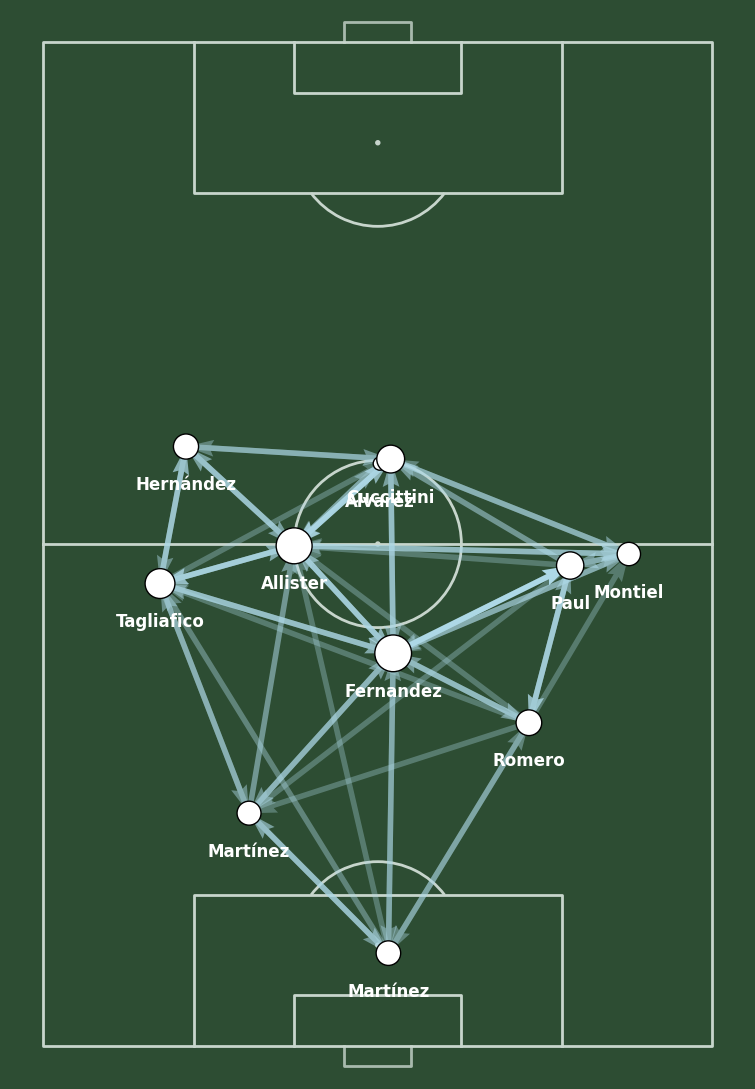

In [ ]:
def preparar_colores_y_tamaños(pass_between, average_locations):
    MAX_LINE_WIDTH = 6  # Reducir el tamaño de las flechas
    pass_between['width'] = pass_between.pass_count / pass_between.pass_count.max() * MAX_LINE_WIDTH

    MIN_TRANSPARENCY = 0.2  # Aumentar la transparencia
    # Crear un array de colores con la longitud de pass_between
    color = np.array([to_rgba('lightblue', alpha=0.5)] * len(pass_between))  # Color más suave y con transparencia

    # Calcular la transparencia para las flechas
    c_transparency = pass_between.pass_count / pass_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency  # Asignar la transparencia correctamente

    # Ajustar el tamaño de los círculos de los jugadores basado en los pases
    MAX_MARKER_SIZE = 700
    average_locations['marker_size'] = average_locations['count'] / average_locations['count'].max() * MAX_MARKER_SIZE

    return color, average_locations

# Crear el campo y graficar
pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#2d4d33', line_color='#c7d5cc', goal_type='box', goal_alpha=.8)
fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#2d4d33')

# Dibujar flechas para los pases con menos tamaño y mejor color
arrows = pitch.arrows(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, ax=ax, color=color, zorder=.99, linewidth=pass_between['width'])

# Dibujar nodos para las posiciones promedio de los jugadores
nodes = pitch.scatter(average_locations.x, average_locations.y, ax=ax, color='white', ec='black', s=average_locations['marker_size'], zorder=1)

# Agregar nombres de jugadores sin los números de camiseta (ajustando la visibilidad)
for index, row in pass_between[['pasador', 'x', 'y']].drop_duplicates(subset='pasador').iterrows():
    # Agregar nombre del jugador
    pitch.annotate(row.pasador.split(' ')[-1], xy=(row.x-4.5, row.y), c='white', va='center', ha='center', size=12, weight='bold', ax=ax, zorder=1)

# Mostrar el gráfico
plt.show()

In [ ]:
#Hasta acá es solo al primer cambio

In [ ]:
for i, tramo in enumerate(tramos):
    start_time, end_time = tramo
    eventos_tramo = partido[(partido['minute'] >= start_time) & (partido['minute'] < end_time)]
    print(f"Tramo {i+1}: Minuto {start_time}-{end_time} → {len(eventos_tramo)} eventos totales")


Tramo 1: Minuto 0-65 → 2363 eventos totales
Tramo 2: Minuto 65-71 → 165 eventos totales
Tramo 3: Minuto 71-96 → 813 eventos totales
Tramo 4: Minuto 96-96 → 0 eventos totales
Tramo 5: Minuto 96-96 → 0 eventos totales
Tramo 6: Minuto 96-116 → 563 eventos totales
Tramo 7: Minuto 116-124 → 196 eventos totales


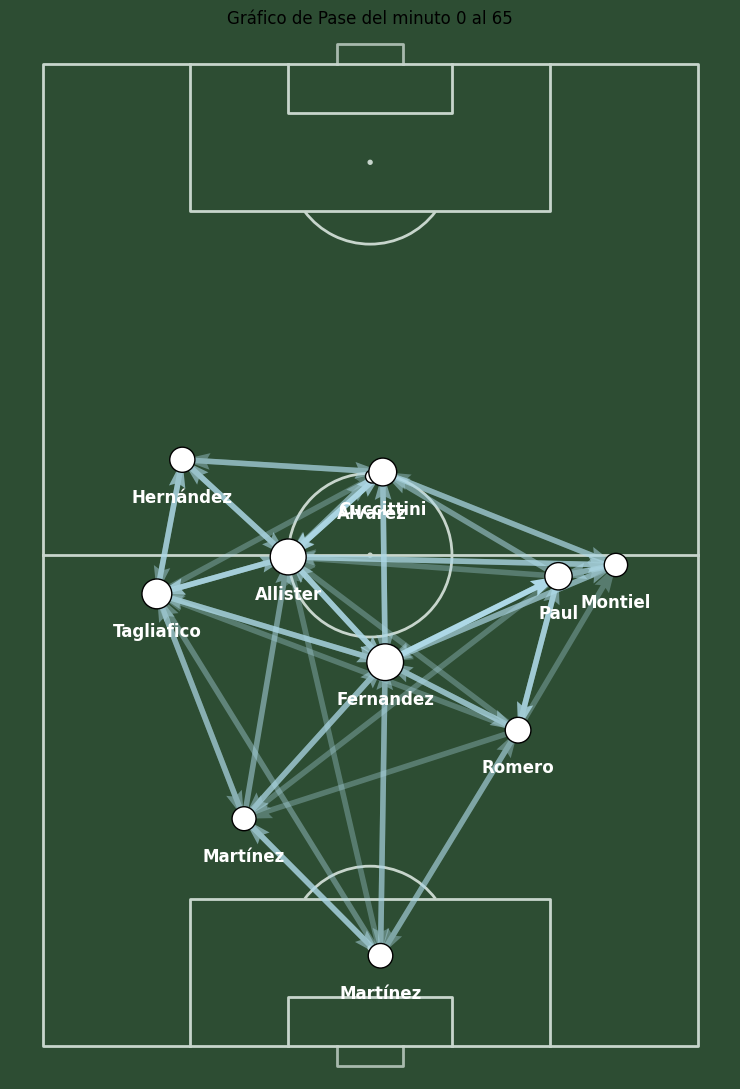

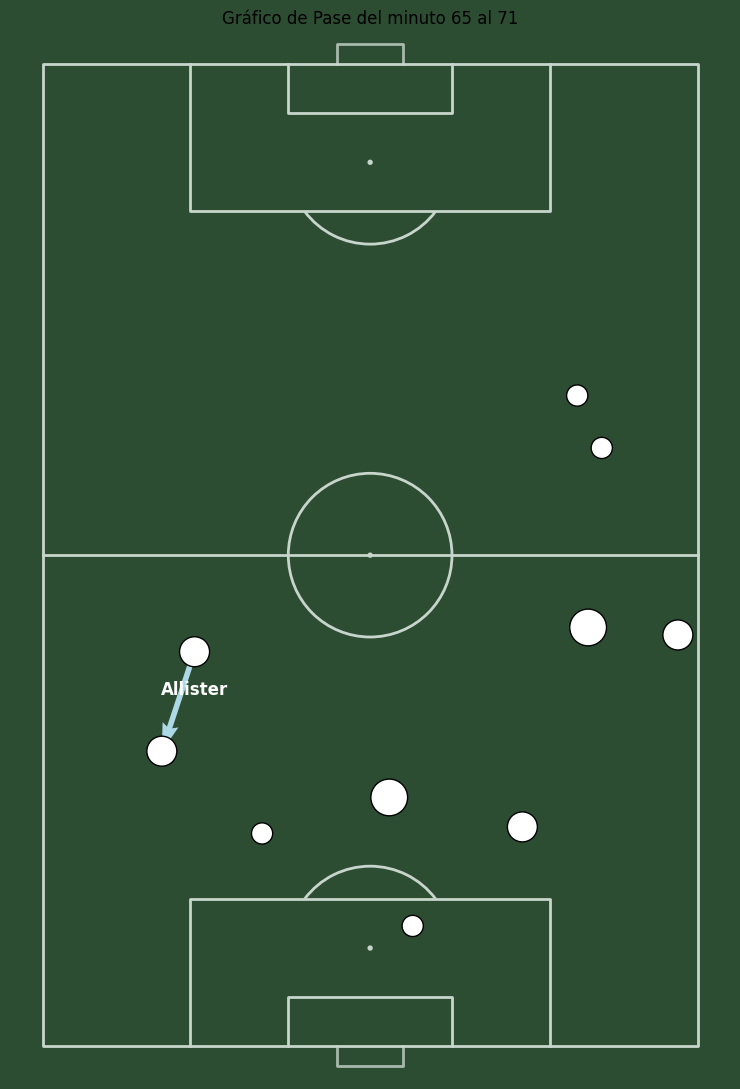

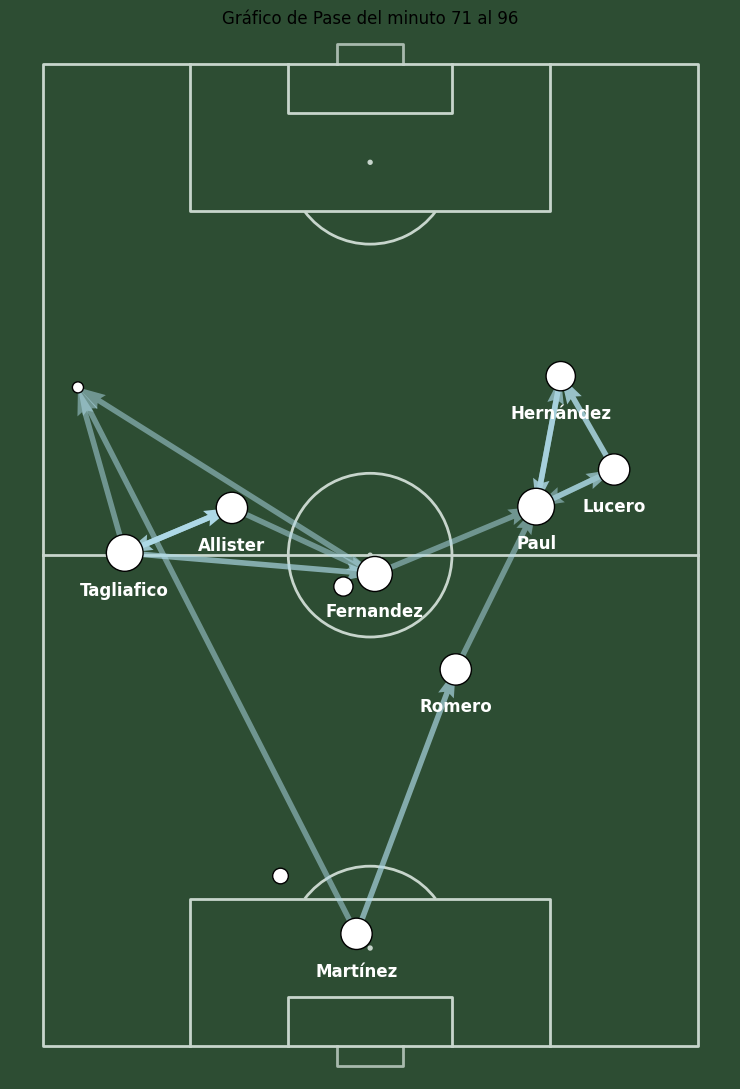

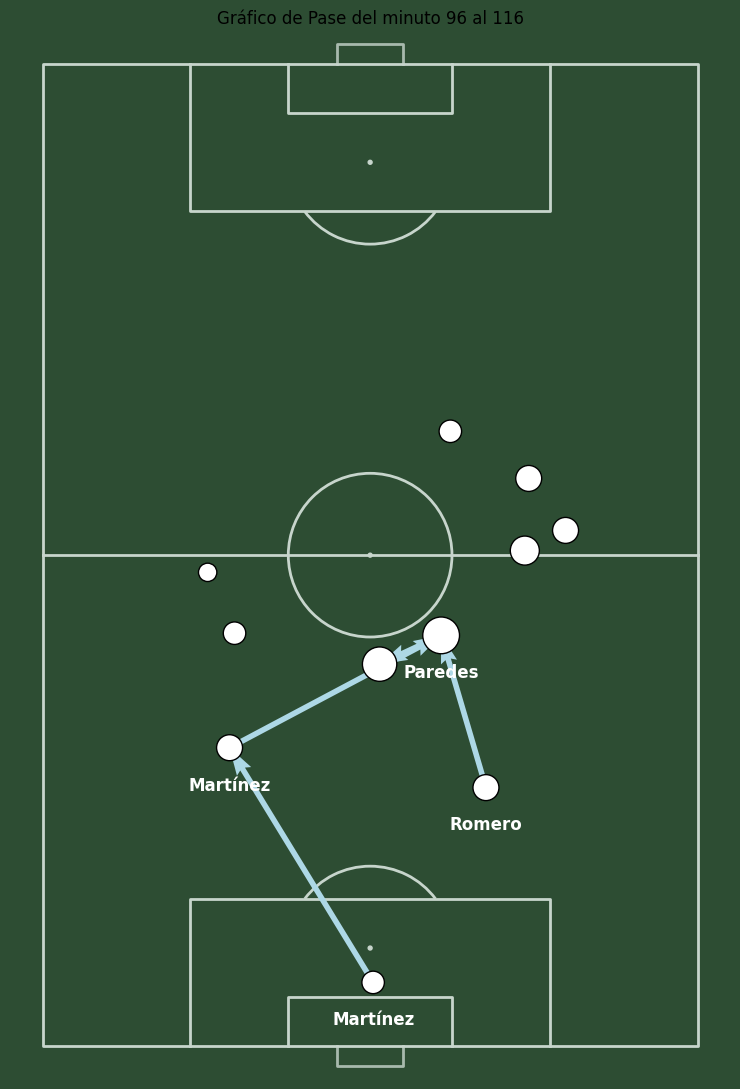

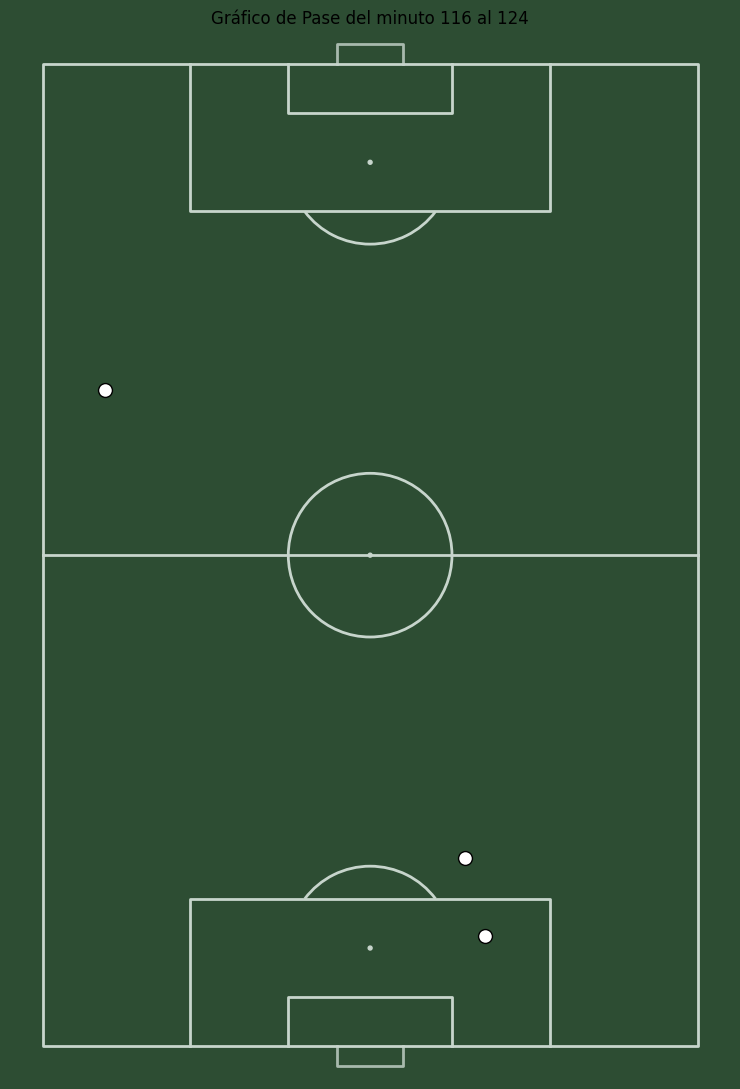

In [ ]:
def obtener_datos_partido(match_id):
    partido = sb.events(match_id=match_id)
    partido[['x', 'y']] = partido['location'].apply(pd.Series)
    partido[['end_x', 'end_y']] = partido['pass_end_location'].apply(pd.Series)
    partido['pasador'] = partido['player']
    partido['receptor'] = partido['player'].shift(-1)
    return partido

def obtener_pases_completados(partido, equipo):
    pases_partido = partido[(partido['type'] == 'Pass') & (partido['team'] == equipo)]
    completados = pases_partido[pases_partido['pass_outcome'].isna()]
    return completados

def calcular_promedios_y_pases(pases_completados):
    if pases_completados.empty:
        return pd.DataFrame(), pd.DataFrame()

    average_locations = pases_completados.groupby('player').agg({'x': ['mean'], 'y': ['mean', 'count']})
    average_locations.columns = ['x', 'y', 'count']

    pass_between = pases_completados.groupby(['pasador', 'receptor']).id.count().reset_index()
    pass_between.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    pass_between = pass_between.merge(average_locations, left_on='pasador', right_index=True)
    pass_between = pass_between.merge(average_locations, left_on='receptor', right_index=True, suffixes=['', '_end'])

    pass_between = pass_between[pass_between['pass_count'] > 1]
    return pass_between, average_locations

def obtener_cambios(partido, equipo):
    cambios = partido[(partido['type'] == 'Substitution') & (partido['team'] == equipo)]
    return cambios['minute'].values

def fusionar_cambios(cambios, umbral=5):
    if len(cambios) == 0:
        return []

    cambios_fusionados = [cambios[0]]
    for minuto in cambios[1:]:
        if minuto - cambios_fusionados[-1] > umbral:
            cambios_fusionados.append(minuto)
    return cambios_fusionados

def crear_subsets(partido, cambios):
    tramos = [(0, cambios[0])] if cambios else [(0, partido['minute'].max())]

    for i in range(1, len(cambios)):
        tramos.append((cambios[i-1], cambios[i]))

    if cambios:
        tramos.append((cambios[-1], partido['minute'].max()))

    return tramos

def preparar_colores_y_tamaños(pass_between, average_locations):
    if pass_between.empty or average_locations.empty:
        return np.array([]), average_locations

    MAX_LINE_WIDTH = 6
    pass_between['width'] = pass_between.pass_count / pass_between.pass_count.max() * MAX_LINE_WIDTH

    MIN_TRANSPARENCY = 0.2
    color = np.array([to_rgba('lightblue', alpha=0.5)] * len(pass_between))

    c_transparency = pass_between.pass_count / pass_between.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    if len(color) > 0:
        color[:, 3] = c_transparency

    if 'count' in average_locations and not average_locations.empty:
        MAX_MARKER_SIZE = 700
        average_locations['marker_size'] = average_locations['count'] / average_locations['count'].max() * MAX_MARKER_SIZE

    return color, average_locations

def generar_grafico_para_tramo(partido, tramo, equipo):
    start_time, end_time = tramo
    partido_tramo = partido[(partido['minute'] >= start_time) & (partido['minute'] < end_time)]

    pases_completados = obtener_pases_completados(partido_tramo, equipo)
    pass_between, average_locations = calcular_promedios_y_pases(pases_completados)
    color, average_locations = preparar_colores_y_tamaños(pass_between, average_locations)

    pitch = VerticalPitch(pitch_type='statsbomb', pitch_color='#2d4d33', line_color='#c7d5cc', goal_type='box', goal_alpha=.8)
    fig, ax = pitch.draw(figsize=(16, 11), constrained_layout=False, tight_layout=True)
    fig.set_facecolor('#2d4d33')

    if not pass_between.empty:
        pitch.arrows(pass_between.x, pass_between.y, pass_between.x_end, pass_between.y_end, ax=ax, color=color, zorder=.99, linewidth=pass_between['width'])

    if not average_locations.empty:
        pitch.scatter(average_locations.x, average_locations.y, ax=ax, color='white', ec='black', s=average_locations.get('marker_size', 100), zorder=1)

        for index, row in pass_between[['pasador', 'x', 'y']].drop_duplicates(subset='pasador').iterrows():
            pitch.annotate(row.pasador.split(' ')[-1], xy=(row.x-4.5, row.y), c='white', va='center', ha='center', size=12, weight='bold', ax=ax, zorder=1)

    plt.title(f'Gráfico de Pase del minuto {start_time} al {end_time}')
    plt.show()

# Código principal
partido = obtener_datos_partido(3943077)
cambios = obtener_cambios(partido, 'Argentina')
cambios_fusionados = fusionar_cambios(cambios)
tramos = crear_subsets(partido, cambios_fusionados)

for tramo in tramos:
    generar_grafico_para_tramo(partido, tramo, 'Argentina')


In [ ]:
#Hasta acá bien en general. Hay que cambiarlo a en vez de pases, que sean todos los eventos y tome una posición en el campo.
#Podría hacer que los jugadores que salen sigan marcado en el grafico pero en oscuro.
#

In [ ]:
for i, tramo in enumerate(tramos):
    start_time, end_time = tramo
    pases_tramo = partido[(partido['minute'] >= start_time) & (partido['minute'] < end_time)]
    print(f"Tramo {i+1}: Minuto {start_time}-{end_time} → {len(pases_tramo)} pases")


NameError: name 'tramos' is not defined